## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os
from pathlib import Path

In [3]:
import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="1" # use the second gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [4]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

file: V27-30bar_LEM1

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>

Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>

Points:
(442046,)

shift_opts_freqs_all:
(121, 442046)



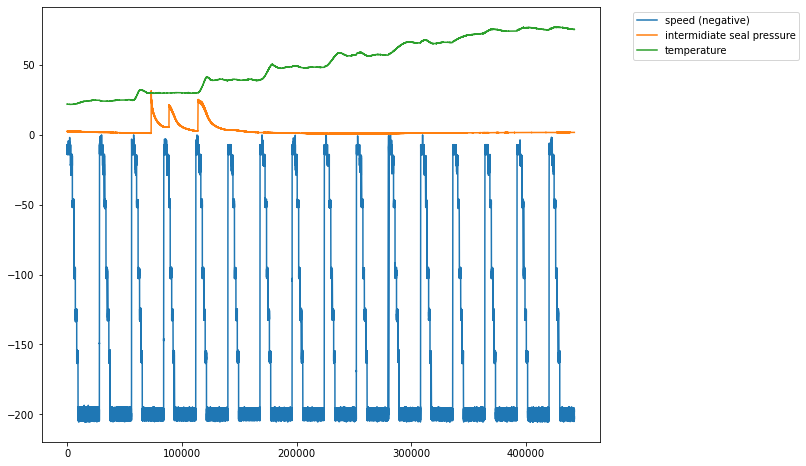

In [5]:
num = 2  # TODO
file = file_list_LEM1[num]
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/V27/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")
print("file:",filename)
print("\nATTR:")
print(h51.attrs.keys())
print("\nKeys:")
print(h51.keys())
print("\nPoints:")
print(h51['t'].shape)
print("\nshift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)
print()

#     # print look up dictionary
#     json_object = json.loads(h51.attrs["name_lookup"])
#     json_formatted_str = json.dumps(json_object, indent=2)
#     print("\nLOOKUP:")
#     print(json_formatted_str)

# plot of speed, isp and temperature
fidx = 20
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(h51['spd1'],label='speed (negative)')
plt.plot(h51['ip1k1'],label='intermidiate seal pressure')
plt.plot(h51['k1t'],label='temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


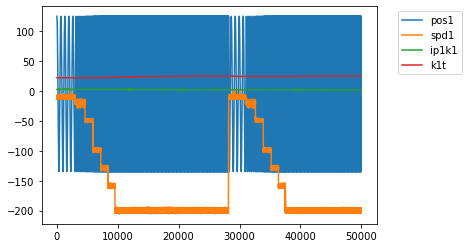

In [6]:
GT = ['pos1','spd1','ip1k1','k1t']
for gt in GT:
    plt.plot(h51[gt][:50000], label = gt)
plt.legend(bbox_to_anchor=(1.05, 1))

In [7]:
low = np.where(h51['spd1'][:]>-40)[0]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
print("timestamps of Ls:")
print (Ls)

Fs = np.append(low[0],low[low_sep+1])
print("timestamps of Fs:")
print (Fs)

print("Durations of lsa:\n",Ls-Fs)

timestamps of Ls:
[  4617  32606  60598  88582 116569 144557 172546 200534 228520 256510
 284496 312484 340472 368461 396447 424436]
timestamps of Fs:
[     0  28211  56199  84192 112177 140163 168150 196140 224128 252114
 280104 308091 336079 364065 392055 420041]
Durations of lsa:
 [4617 4395 4399 4390 4392 4394 4396 4394 4392 4396 4392 4393 4393 4396
 4392 4395]


In [8]:
# set up model saving folder
if num == 0:
    SAVED_IN = DIR + "/models/V27/100bar/"
if num == 1:
    SAVED_IN = DIR + "/models/V27/200bar/"
if num == 2:
    SAVED_IN = DIR + "/models/V27/30bar/"
    
SAVED_IN = os.path.abspath(SAVED_IN)
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)


In [9]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
y = np.vstack(
    (
        np.asarray(h51['pos1'][N:]),
        np.asarray(h51['spd1'][N:]),
        np.asarray(h51['ip1k1'][N:]),
        np.asarray(h51['k1t'][N:])
    )
)
y = y.T
print("X:")
print(X.shape)
print("y:")
print(y.shape)

X:
(441946, 242)
y:
(441946, 4)


In [10]:
h51.close()

## Preprocessing

In [11]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, y_train2, y_val, idx_train2, idx_val = train_test_split(X_train, y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_test.shape)

(353556, 242)
(88390, 242)


In [12]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
# scaler.mean_.shape

In [13]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))

# BATCH_SIZE = 64

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

## Hyperparameter fine-tuning

In [14]:
# def baseline_model():
#   model = keras.Sequential([
#       layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
#       layers.Dense(64, kernel_initializer='normal',activation='relu'),
#       layers.Dense(4,activation='linear')
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#   return model

In [15]:
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

# # evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
# kfold = KFold(n_splits=3)
# results = cross_val_score(estimator, X_val_scaled, y_val, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (abs(results.mean()), results.std()))

## Training

### Baseline model with normalization

In [16]:
MODEL_NAME = "NN_baseline_combi"

In [17]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [18]:
def baseline_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [19]:
NN_baseline = baseline_model(normalizer)
NN_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 40,105
Trainable params: 39,620
Non-trainable params: 485
_________________________________________________________________


In [20]:
%%time
history = NN_baseline.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=0, epochs=100)

Wall time: 31min 50s


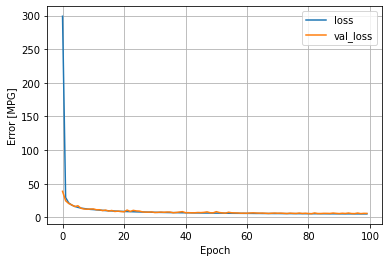

In [21]:
plot_loss(history)

In [22]:
NN_baseline.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\30bar\NN_baseline_combi\assets


In [23]:
# MODEL_NAME = "NN_baseline_combi" 
# NN_baseline = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [24]:
# evaluation on both training and test sets

y_ = NN_baseline.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [25]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,1.959135,2.047224
1,spd1,14.107010,16.436612
2,ip1k1,2.933458,3.065228
3,k1t,2.768886,2.874264


In [26]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  5.4421225228203465
MSE of the prediction on test set:  6.105831944773374


In [27]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
y_train_lsa_ = y_[idx_com_train]
y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(y[idx_com_train] - y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,1.045915,1.098349
1,spd1,22.758020,23.674662
2,ip1k1,3.706006,3.870555
3,k1t,4.430101,4.604569


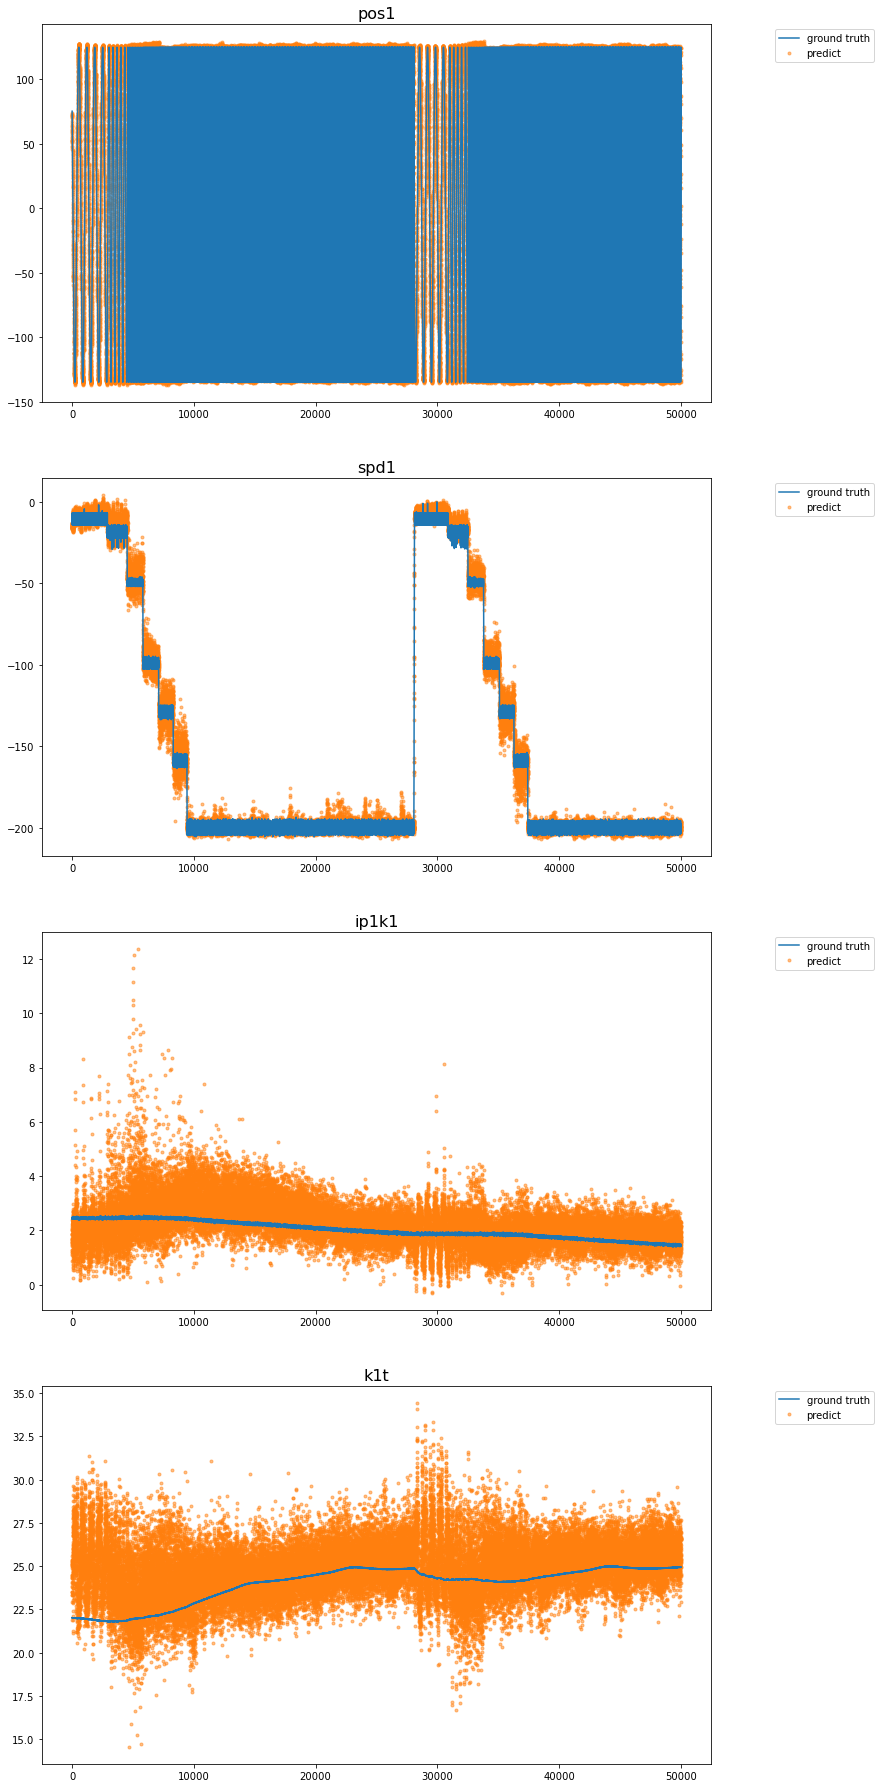

In [28]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

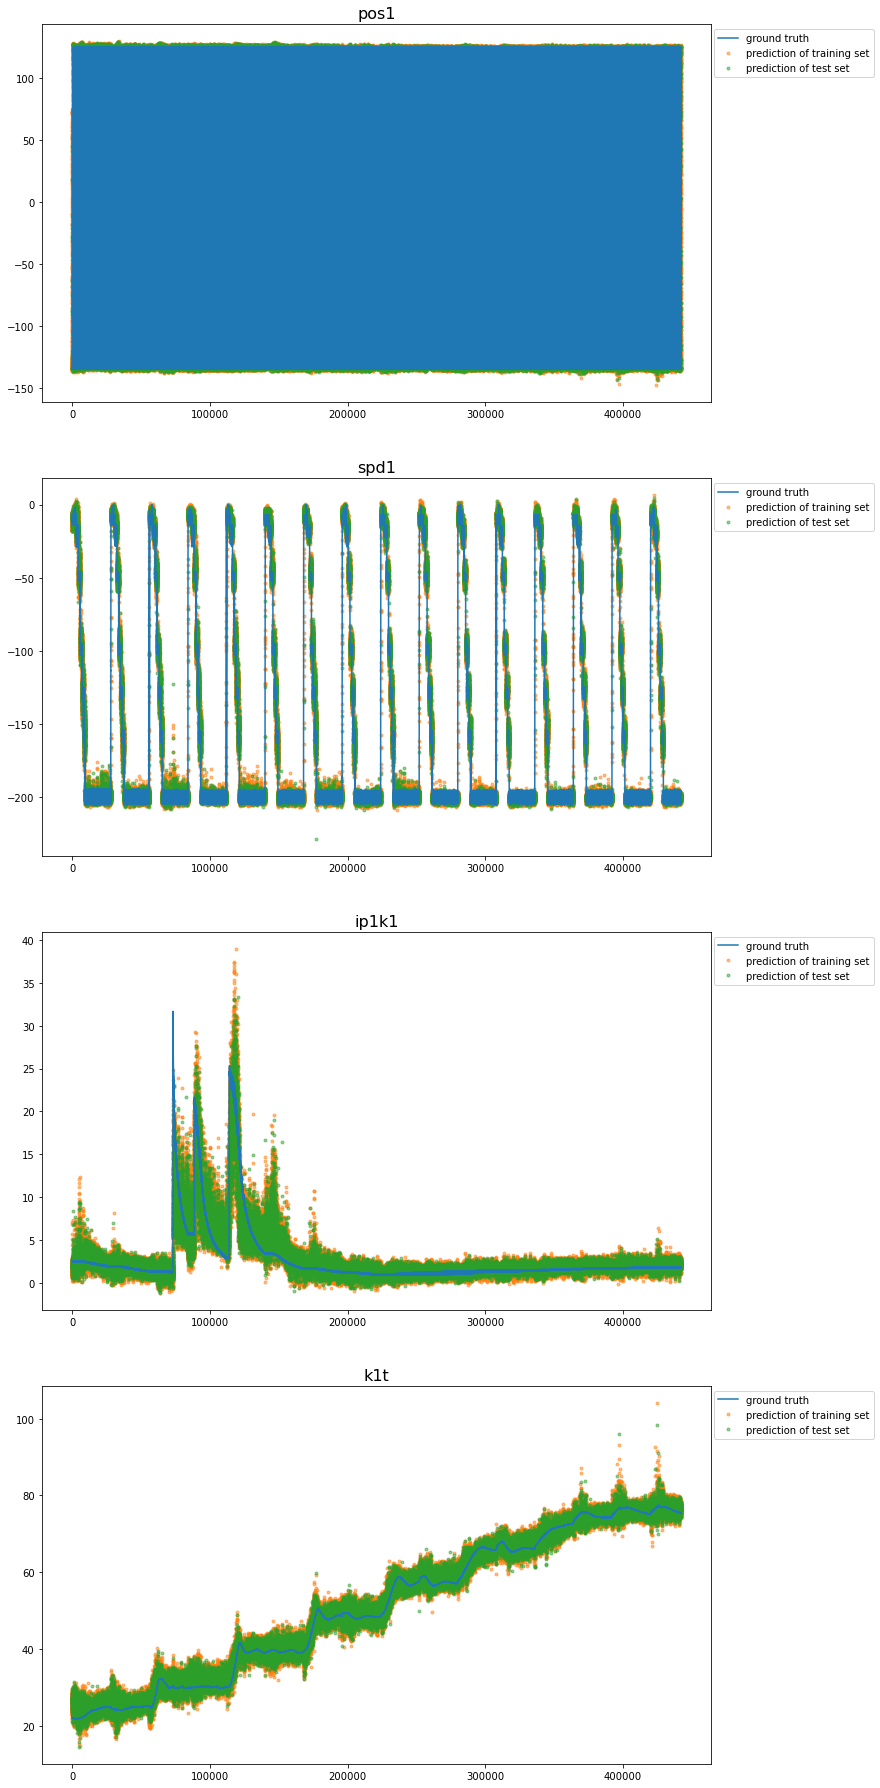

In [29]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### Model of Previous Project

In [30]:
MODEL_NAME = "NN_pp_combi"

In [31]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [32]:
def model_pp(norm):
  model = keras.Sequential([
      norm,
      # layers.Dense(242, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(100, input_dim=242, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [33]:
NN_pp= model_pp(normalizer)
NN_pp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               24300     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 404       
Total params: 25,189
Trainable params: 24,704
Non-trainable params: 485
_________________________________________________________________


In [34]:
%%time
history = NN_pp.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=0, epochs=100)

Wall time: 28min 19s


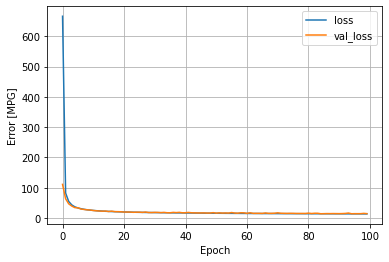

In [35]:
plot_loss(history)

In [36]:
NN_pp.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\30bar\NN_pp_combi\assets


In [37]:
# MODEL_NAME = "NN_pp_combi" 
# NN_pp = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [38]:
# evaluation on both training and test sets

y_ = NN_pp.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [39]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.197250,4.276326
1,spd1,36.311094,40.230884
2,ip1k1,6.612504,6.637494
3,k1t,7.003964,7.061464


In [40]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  13.531202921322482
MSE of the prediction on test set:  14.551541989504301


In [41]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
y_train_lsa_ = y_[idx_com_train]
y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(y[idx_com_train] - y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,2.962897,3.060106
1,spd1,26.375127,27.834707
2,ip1k1,10.650691,10.583672
3,k1t,12.416093,12.609797


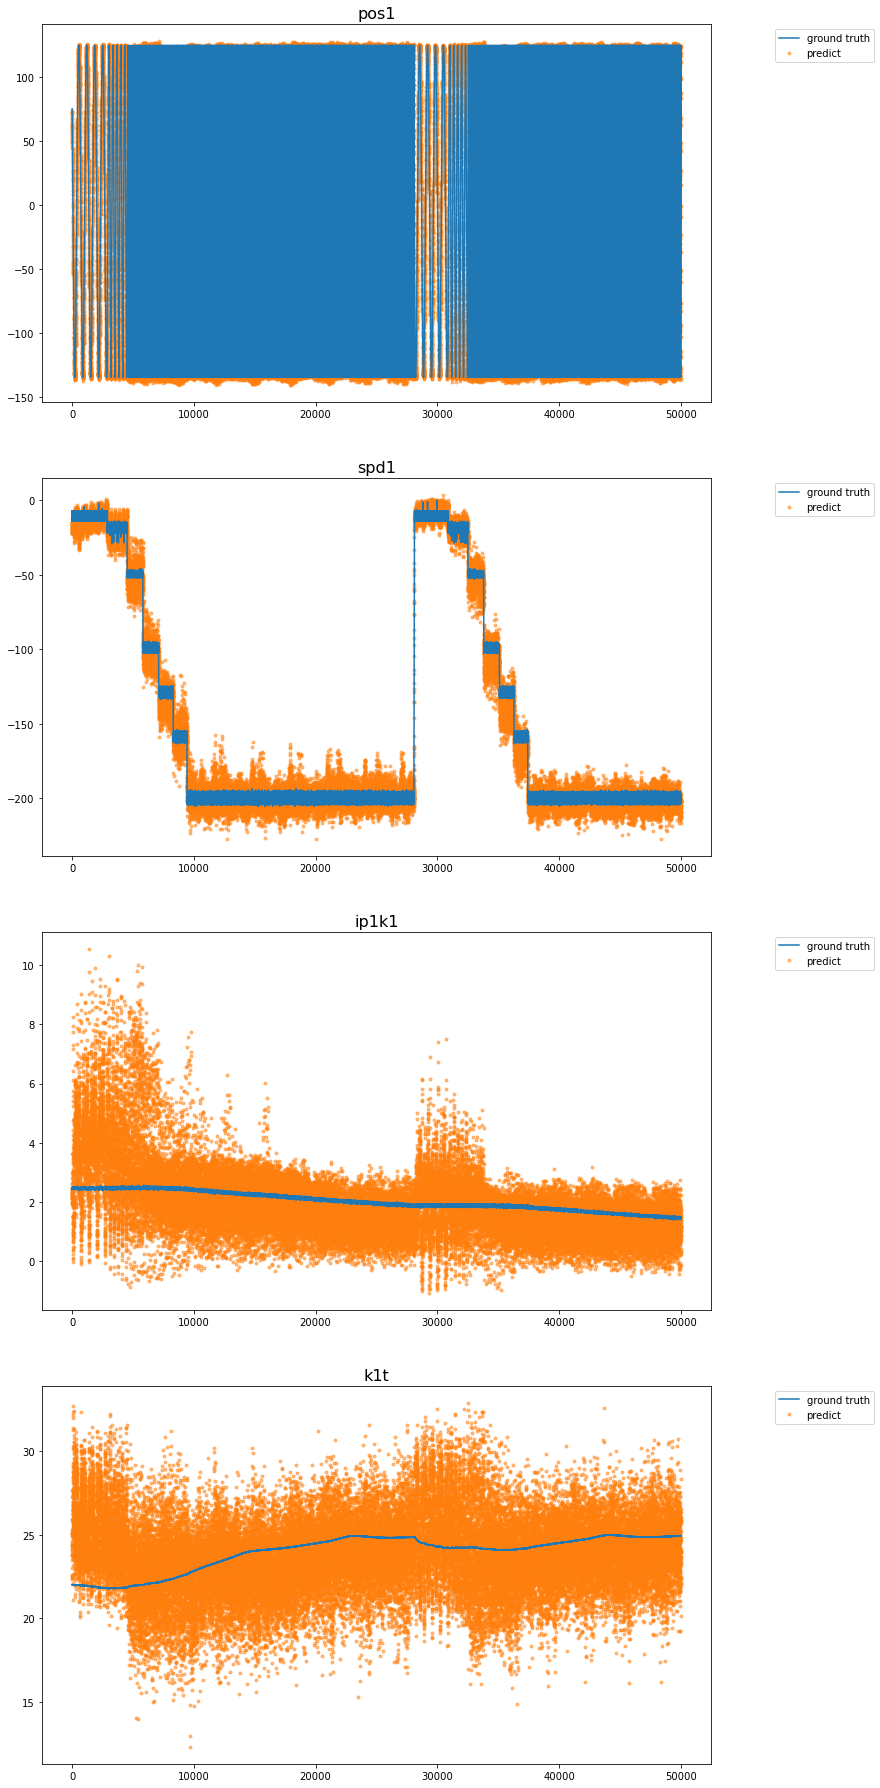

In [42]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

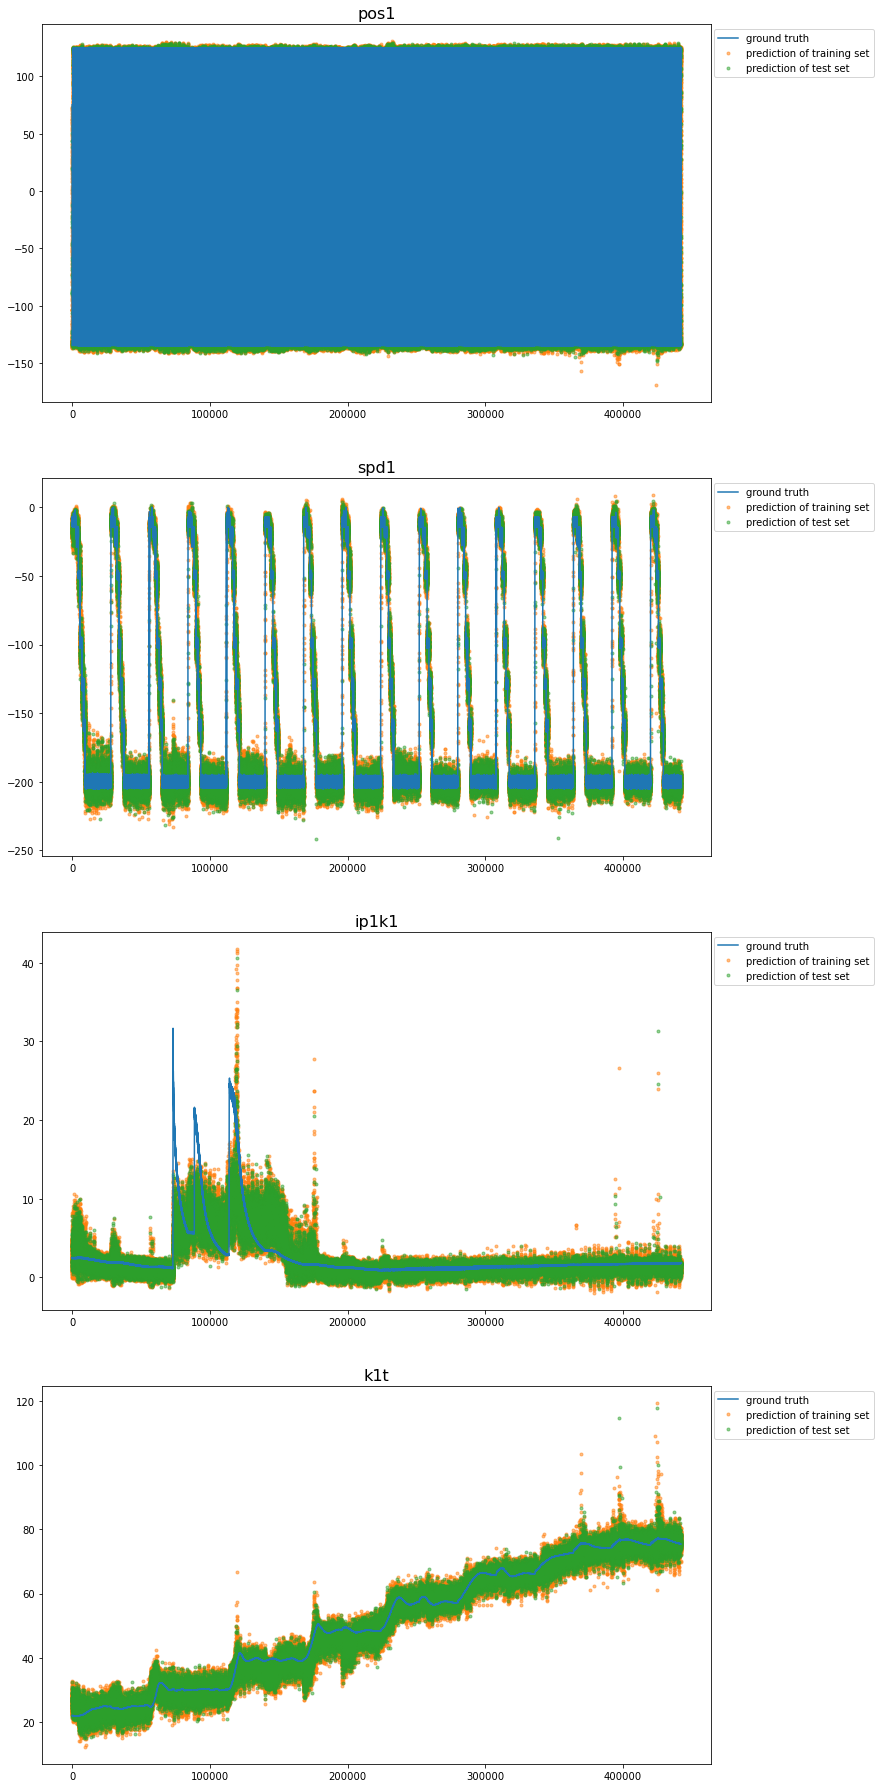

In [43]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### CNN baseline

Conv1D layer expects input shape in 3D as 

**[batch_size, time_steps, input_dimension]**

However, current data is in the shape of 

**[batch_size, features]**

In [44]:
MODEL_NAME = "CNN_baseline_combi"

In [45]:
# normalisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [46]:
# reshape data
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X_train_reshaped = X_train_scaled.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],time_steps,input_dimension)

In [47]:
n_timesteps = X_train_reshaped.shape[1] # 242
n_features  = X_train_reshaped.shape[2] # 1
n_outputs = y_train.shape[1]
def baseline_cnn_model():
  model = keras.Sequential([
      layers.Input(shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=64, kernel_size=7, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(n_outputs)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

CNN = baseline_cnn_model()
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 236, 64)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 118, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 114, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 432)              

In [48]:
%%time
history = CNN.fit(
    X_train_reshaped, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 51min 29s


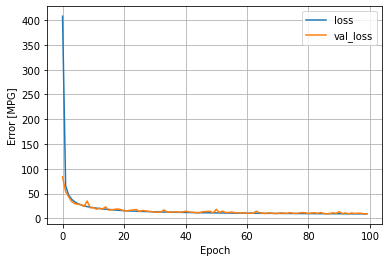

In [49]:
plot_loss(history)

In [50]:
CNN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\30bar\CNN_baseline_combi\assets


In [51]:
# MODEL_NAME = "CNN_baseline_combi"
# CNN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [52]:
# Collect the results on the test set
CNN.evaluate(X_test_reshaped, y_test,verbose = 2)

2763/2763 - 9s - loss: 9.0147


9.014739990234375

In [53]:
X_ = scaler.transform(X)
X_ = X_.reshape(X_.shape[0],time_steps,input_dimension)
y_ = CNN.predict(X_)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [54]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.149662,4.300321
1,spd1,19.777955,22.282176
2,ip1k1,4.048553,4.128933
3,k1t,5.199774,5.347511


In [55]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low)

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on test set and lsa
0,pos1,3.395352
1,spd1,24.398425
2,ip1k1,5.682060
3,k1t,9.283917


In [56]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  8.293986090403239
MSE of the prediction on test set:  9.014735110238915


Those are the results on training set:


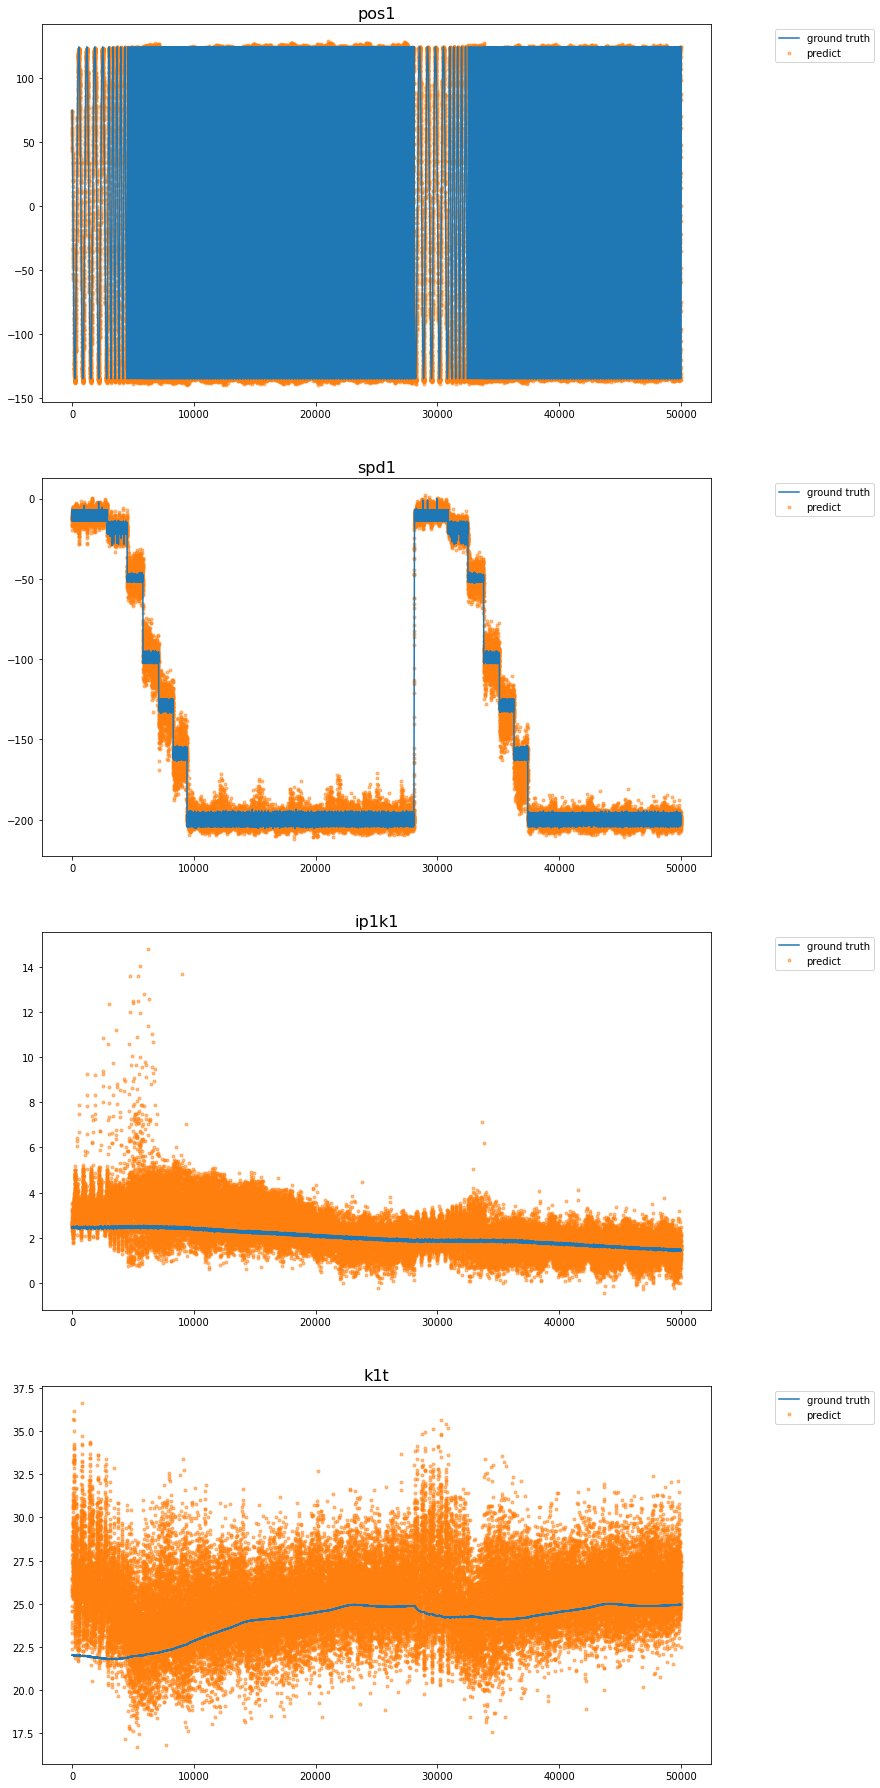

In [57]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
print("Those are the results on training set:")
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

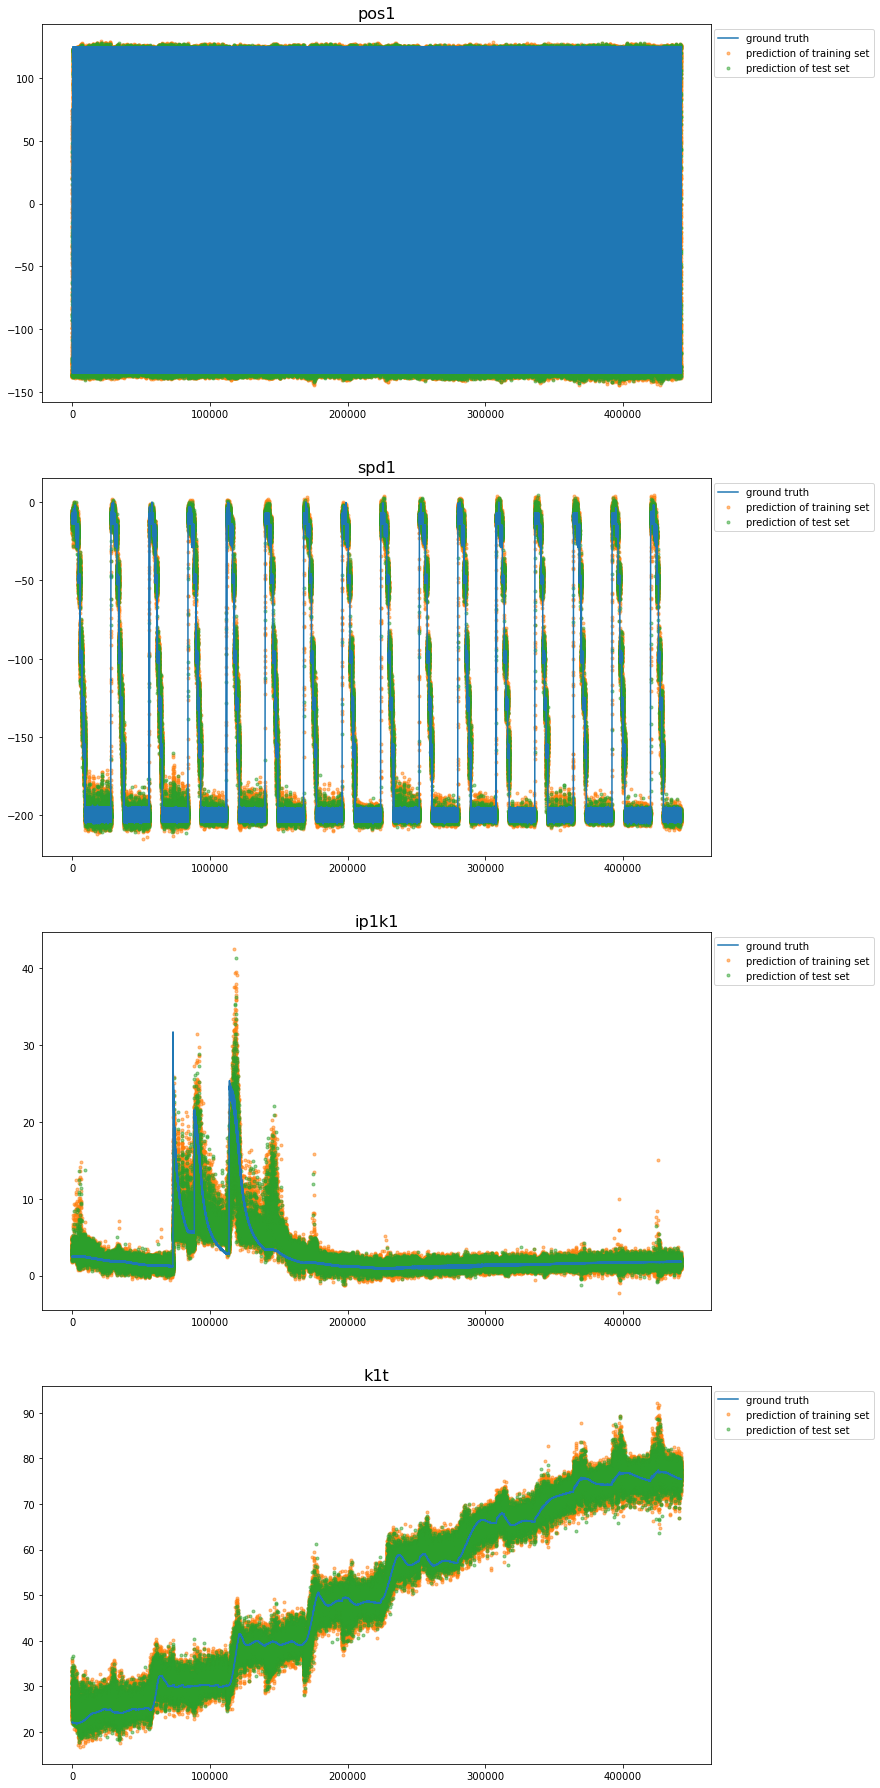

In [58]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### CNN tuning

In [59]:
MODEL_NAME = "CNN_tuning_combi"

In [60]:
# normalisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [61]:
# reshape data
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X_train_reshaped = X_train_scaled.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],time_steps,input_dimension)

In [62]:
n_timesteps = X_train_reshaped.shape[1] # 242
n_features  = X_train_reshaped.shape[2] # 1
n_outputs = y_train.shape[1]
def baseline_cnn_model():
  model = keras.Sequential([
      layers.Input(shape=(n_timesteps,n_features)),
      
        layers.Conv1D(filters=64, kernel_size=10, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(n_outputs)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

CNN = baseline_cnn_model()
CNN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 233, 64)           704       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 116, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 114, 32)           6176      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 55, 16)            1552      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 432)              

In [63]:
%%time
history = CNN.fit(
    X_train_reshaped, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 47min 1s


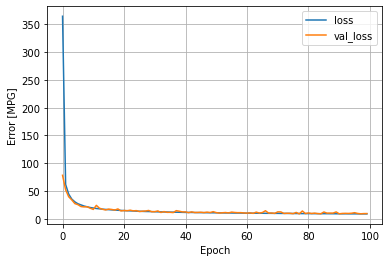

In [64]:
plot_loss(history)

In [65]:
CNN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\30bar\CNN_tuning_combi\assets


In [66]:
# MODEL_NAME = "CNN_tuning_combi"
# CNN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [67]:
# Collect the results on the test set
CNN.evaluate(X_test_reshaped, y_test,verbose = 2)

2763/2763 - 4s - loss: 9.7864


9.786397933959961

In [68]:
X_ = scaler.transform(X)
X_ = X_.reshape(X_.shape[0],time_steps,input_dimension)
y_ = CNN.predict(X_)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [69]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,3.996100,4.061894
1,spd1,23.269954,25.996750
2,ip1k1,3.999601,4.090423
3,k1t,4.868404,4.996569


In [70]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low)

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on test set and lsa
0,pos1,3.119700
1,spd1,27.140604
2,ip1k1,5.216685
3,k1t,8.364578


In [71]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  9.033514976210595
MSE of the prediction on test set:  9.78640911842711


Those are the results on training set:


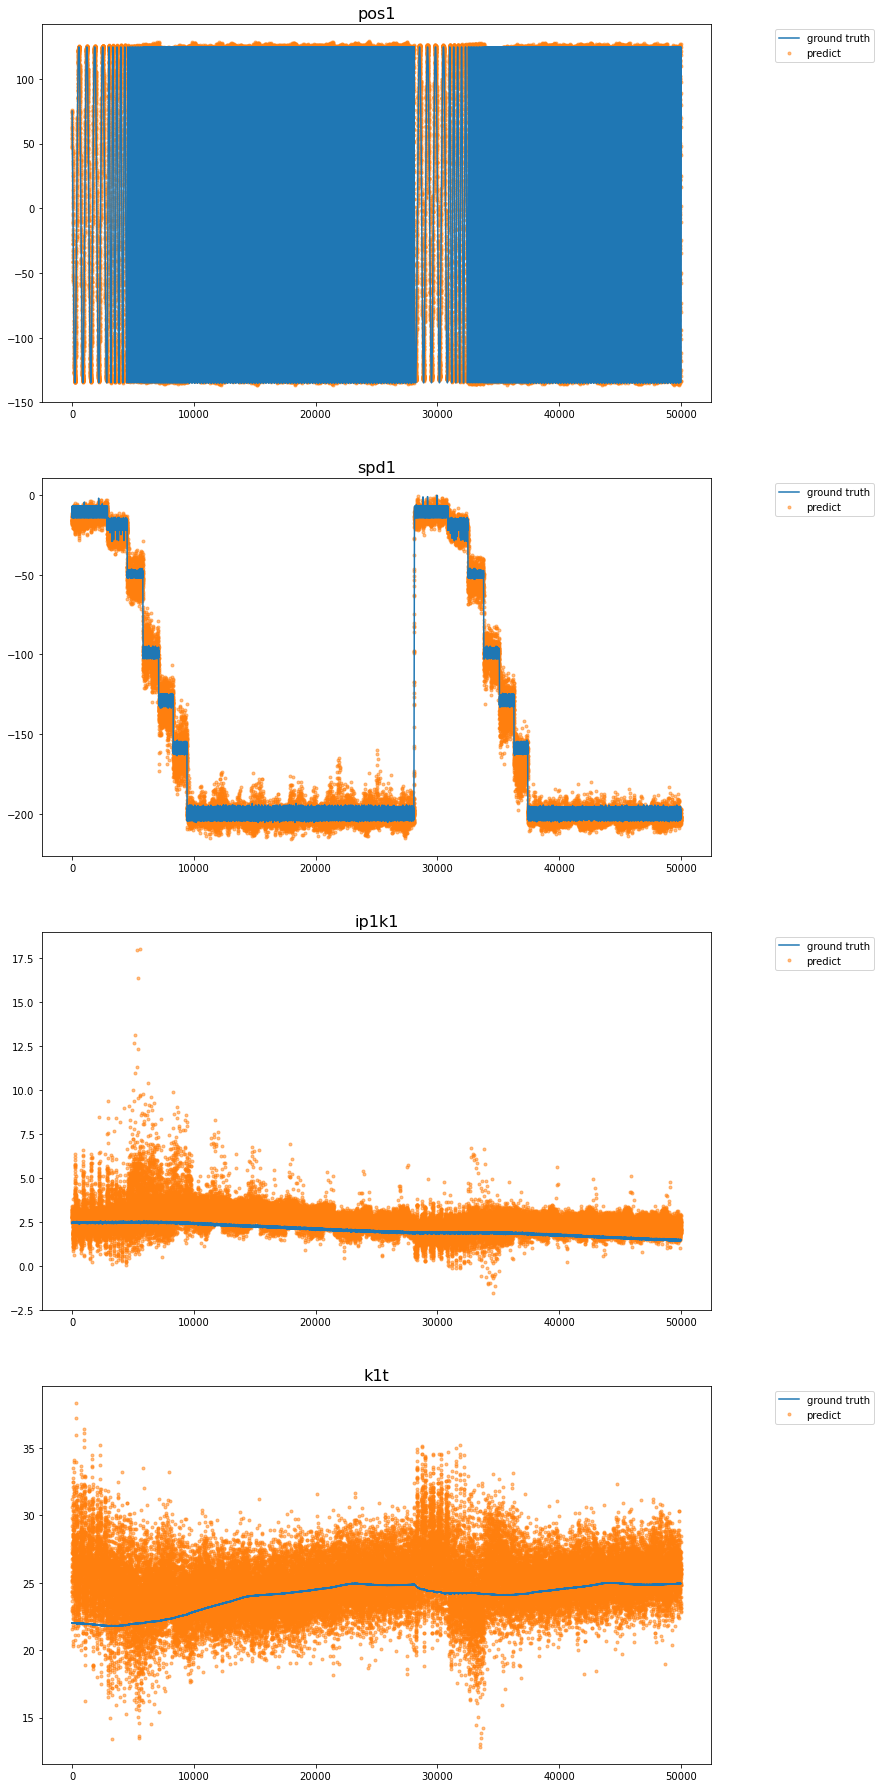

In [72]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
print("Those are the results on training set:")
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

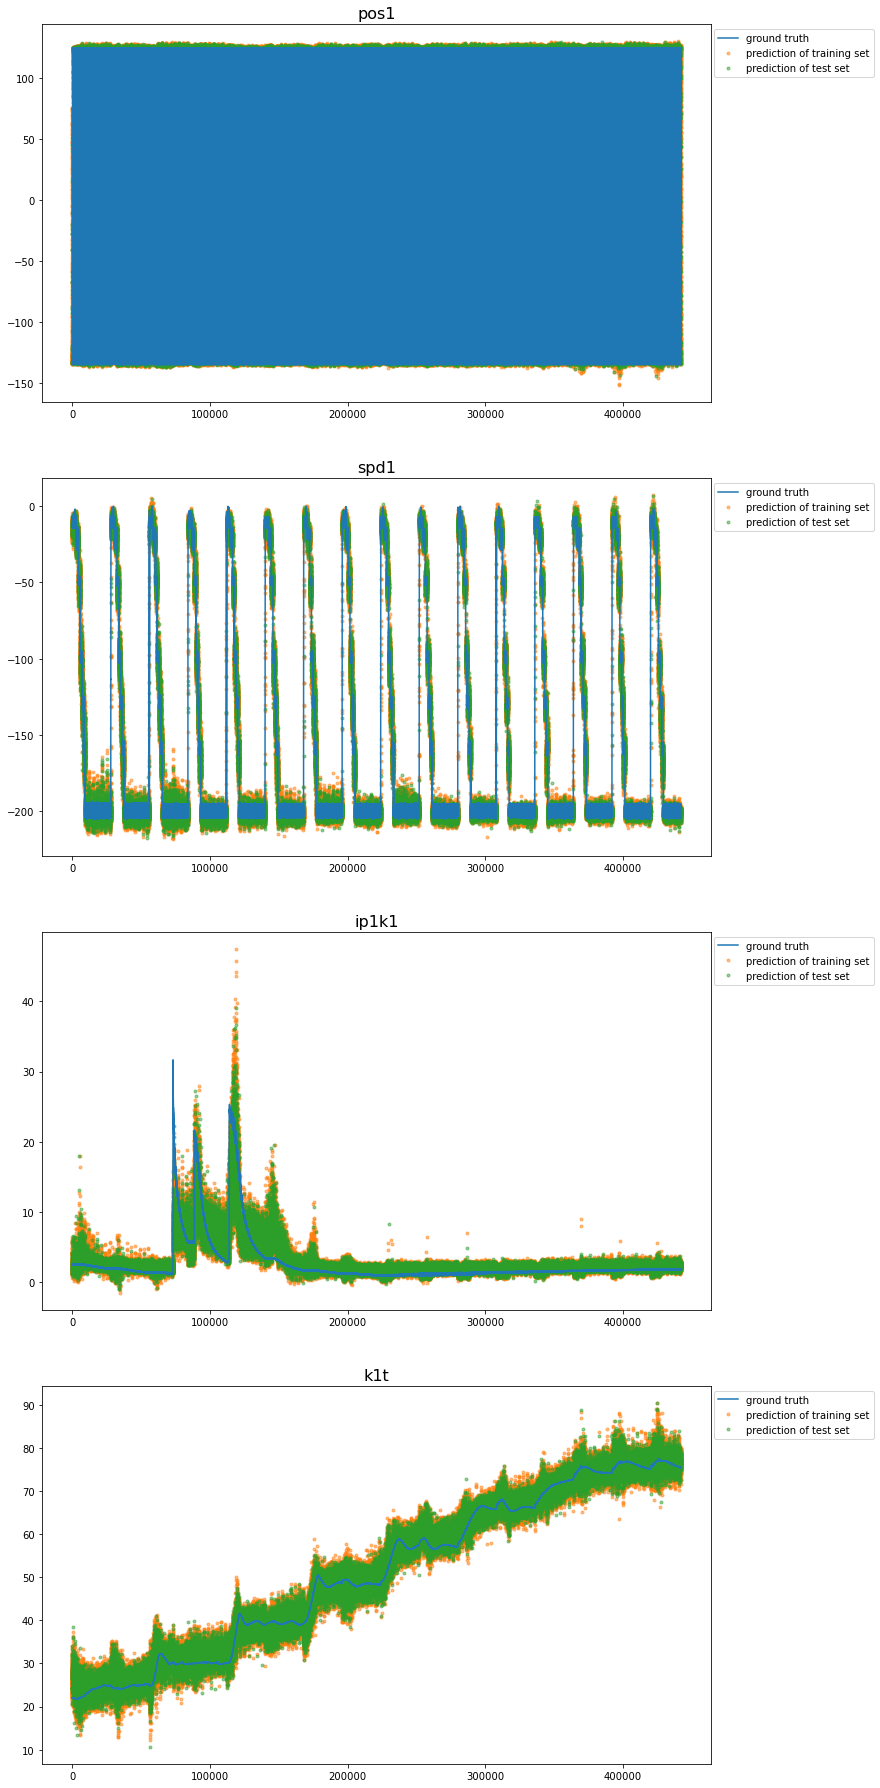

In [73]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)